## SSPS Demo 
## Preprocessing Data Input Tables Site Specific RShiny Demo App
Notes:
- asdf

In [1]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps

# visulizaiton
import seaborn as sns
import matplotlib.pyplot as plt

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Setting work directory
cwd = os.getcwd()
print("current directory = " + cwd)

os.chdir("../NotEssentialData")
print("new directory = " + os.path.abspath(os.curdir))

current directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSPS_Demo\bonus code
new directory = C:\Users\rjame\Documents\WSWC Documents\WaDE Side Projects Local\20221017 Rshiny SS Demo\SSPS_Demo\NotEssentialData


## Inputs

In [3]:
#Sites Input
fileInput = "Sites.csv"
dfs = pd.read_csv(fileInput)
print(len(dfs))
dfs.head(1)

54237


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords
0,CAssps_S1062,SO. CAL. EDISON CO.-SANTA CATALINA,CA1910006,Water Service Area,-118.434483,33.382597,POU,Groundwater,Monthly,Delivered,Cumulative Delivered_Monthly_Agricultural_Unsp...,Yes


## Clean Sites Data

In [4]:
# Clean input
dfs = dfs.drop_duplicates().reset_index(drop=True) # Drop Duplicate Rows
dfs = dfs.replace(np.nan, "")  # Replaces NaN values with blank.
print(len(dfs))
dfs.head(1)

54237


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords
0,CAssps_S1062,SO. CAL. EDISON CO.-SANTA CATALINA,CA1910006,Water Service Area,-118.434483,33.382597,POU,Groundwater,Monthly,Delivered,Cumulative Delivered_Monthly_Agricultural_Unsp...,Yes


In [5]:
# Fixing blank WaDENameWS
def updateWaDENameWS(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameWS'] = dfs.apply(lambda row: updateWaDENameWS(row['WaDENameWS']), axis=1)
dfs['WaDENameWS'].unique()

array(['Groundwater', 'Surface Water', 'Unspecified', 'Reuse',
       'Surface and Groundwater'], dtype=object)

In [6]:
# Groupby SiteUUID
dfs = dfs.groupby(['SiteUUID']).agg(lambda x: ", ".join([str(elem) for elem in (list(set(x))) if elem!=""])).replace(np.nan, "").reset_index()
print(len(dfs))
dfs.head(1)

18040


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Water Service Area,-122.027303326,37.7343636266,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,Yes


In [7]:
# count num of VariableSpecificCV after groupby

def countNumVar(Val):
    Val = list(Val.split(","))
    if Val == [""]:
        ValLen = 0
    else:
        ValLen = len(Val)
    return ValLen

dfs['CountVar'] = dfs.apply(lambda row: countNumVar(row['VariableSpecificCV']), axis=1)
dfs['CountVar'].unique()

array([ 2,  3,  1,  7,  6,  8,  5,  9,  4, 10,  0, 11, 12], dtype=int64)

In [8]:
# add State field

def createState(Val):
    Val = Val.strip()
    outString = Val[:2]
    return outString

dfs['State'] = dfs.apply(lambda row: createState(row['SiteUUID']), axis=1)
dfs['State'].unique()

array(['CA', 'NJ', 'NM', 'TX', 'UT'], dtype=object)

In [9]:
# attach timeframe based on SiteUUID

fileInput = "Sites_timeframe.csv"
dfstf = pd.read_csv(fileInput)
dfs = pd.merge(dfs, dfstf, on='SiteUUID', how='left')
print(len(dfs))
dfs.head(1)

18040


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Water Service Area,-122.027303326,37.7343636266,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,Yes,2,CA,2014-01-01,2016-12-31


In [10]:
# attach geometry based on SiteUUID

fileInput = "Sites_geometry.csv"
dfgeo = pd.read_csv(fileInput)
dfs = pd.merge(dfs, dfgeo, on='SiteUUID', how='left')
print(len(dfs))
dfs.head(1)

18040


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite_x,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd,PODorPOUSite_y,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Water Service Area,-122.027303326,37.7343636266,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,Yes,2,CA,2014-01-01,2016-12-31,POU,POLYGON ((-122.02636000038909 37.7379799998779...


In [11]:
# Temp Fix

# remove lat & long entries that contain a ','
dfs = dfs[dfs['Latitude'].str.contains(',') == False]
dfs = dfs[dfs['Longitude'].str.contains(',') == False]

# Ensure long is < 0 and > -125 (few ID sites out of bounds)
# Ensure lat is > 10 and < 50 (few MT sites out of bounds).
dfs['Latitude'] = pd.to_numeric(dfs['Latitude'], errors='coerce')
dfs['Longitude'] = pd.to_numeric(dfs['Longitude'], errors='coerce')
dfs = dfs[(dfs['Latitude'].astype(int) > 10) & (dfs['Latitude'].astype(int) < 50)]
dfs = dfs[(dfs['Longitude'].astype(int) < 0) & (dfs['Longitude'].astype(int) > -125)]

print(len(dfs))
dfs.head(1)

18040


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite_x,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd,PODorPOUSite_y,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Water Service Area,-122.027303,37.734364,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,Yes,2,CA,2014-01-01,2016-12-31,POU,POLYGON ((-122.02636000038909 37.7379799998779...


In [12]:
# # Issue of ESRI Shapefile does not support datetime fields

# dfs['minTimeFrameStart'] = pd.to_datetime(dfs['minTimeFrameStart'], errors = 'coerce')
# dfs['maxTimeFrameEnd'] = pd.to_datetime(dfs['maxTimeFrameEnd'], errors = 'coerce')
# print(dfs['minTimeFrameStart'].min())
# print(dfs['maxTimeFrameEnd'].max())

In [13]:
#Inspect output
dfs

,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite_x,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd,PODorPOUSite_y,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Water Service Area,-122.027303,37.734364,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,Yes,2,CA,2014-01-01,2016-12-31,POU,POLYGON ((-122.02636000038909 37.7379799998779...
1,CAssps_S10,ALAMEDA COUNTY FAIRGROUNDS,CA0105020,Water Service Area,-121.887236,37.661659,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Landscape Irrigat...,Yes,3,CA,2013-01-01,2016-12-31,POU,POLYGON ((-121.88789999944797 37.6622299998386...
2,CAssps_S100,FOREST RANCH CHARTER SCHOOL,CA0400079,Water Service Area,-121.667045,39.884413,POU,"Surface Water, Unspecified, Groundwater",Monthly,Produced,Cumulative Produced_Monthly_Total_Groundwater,Yes,1,CA,2014-01-01,2016-12-31,POU,POLYGON ((-121.6677100001466 39.88542000026367...
3,CAssps_S1000,LANCASTER PARK MOBILE HOME PARK,CA1900038,Water Service Area,-118.131822,34.746266,POU,"Surface Water, Unspecified, Groundwater",Monthly,Produced,Cumulative Produced_Monthly_Total_Groundwater,Yes,1,CA,2016-01-01,2016-12-31,POU,POLYGON ((-118.13252999981032 34.7459100000641...
4,CAssps_S1001,PETER PITCHESS HONOR RANCHO DETN. CTR,CA1900046,Water Service Area,-118.595689,34.465742,POU,"Surface Water, Unspecified, Groundwater",Monthly,Produced,Cumulative Produced_Monthly_Total_Groundwater,Yes,1,CA,2013-01-01,2016-12-31,POU,MULTIPOLYGON (((-118.60232725927787 34.4652590...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18035,UTssps_S995,Well #1,POD108542928,Well,-112.098703,41.256292,POD,Groundwater,Annual,Withdrawal,Withdrawal_Monthly_Agricultural_Groundwater,Yes,1,UT,2015-01-01,2021-12-31,POD,NaN
18036,UTssps_S996,Well #2,POD108542932,Well,-112.093757,41.256369,POD,Groundwater,Annual,Withdrawal,Withdrawal_Monthly_Agricultural_Groundwater,Yes,1,UT,2015-01-01,2021-12-31,POD,NaN
18037,UTssps_S997,Tollgate Well #3 (WS003),POD108542937,Well,-111.498348,40.796333,POD,Groundwater,Annual,Withdrawal,Withdrawal_Monthly_Water Supplier_Groundwater,Yes,1,UT,2013-01-01,2021-12-31,POD,NaN
18038,UTssps_S998,Contact (#1) Well (WS004),POD108542958,Well,-111.511629,40.805735,POD,Groundwater,Annual,Withdrawal,Withdrawal_Monthly_Water Supplier_Groundwater,Yes,1,UT,2015-01-01,2019-08-31,POD,NaN


In [14]:
dfs['WaDENameS'].unique()

array(['Water Service Area', 'Other', 'Township', 'City', 'Borough',
       'Town', 'Village', 'Surface Water', 'Well',
       'Canal / Ditch / Stream', '', 'Lake', 'Reservoir', 'Spring', '`',
       'Drain', 'Creek / Spring'], dtype=object)

In [15]:
dfs['WaDENameWS'].unique()

array(['Surface Water, Unspecified, Groundwater',
       'Surface Water, Groundwater, Unspecified', 'Unspecified',
       'Groundwater',
       'Surface Water, Surface and Groundwater, Groundwater',
       'Surface Water, Groundwater',
       'Surface Water, Surface and Groundwater, Groundwater, Unspecified',
       'Surface Water, Unspecified, Surface and Groundwater, Groundwater',
       'Surface Water', 'Unspecified, Groundwater',
       'Surface and Groundwater', 'Surface and Groundwater, Groundwater',
       'Reuse, Groundwater', 'Surface Water, Reuse, Groundwater',
       'Surface Water, Reuse'], dtype=object)

In [16]:
dfs['VariableCV'].unique()

array(['Produced, Delivered', 'Produced', 'Delivered', '', 'Withdrawal',
       'Withdrawal, Return', 'Return', 'Intake', 'Transfer In',
       'Transfer Out', 'Delivered Water Use'], dtype=object)

In [17]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18040 entries, 0 to 18039
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SiteUUID                   18040 non-null  object 
 1   SiteName                   18040 non-null  object 
 2   SiteNativeID               18040 non-null  object 
 3   WaDENameS                  18040 non-null  object 
 4   Longitude                  18040 non-null  float64
 5   Latitude                   18040 non-null  float64
 6   PODorPOUSite_x             18040 non-null  object 
 7   WaDENameWS                 18040 non-null  object 
 8   AggregationIntervalUnitCV  18040 non-null  object 
 9   VariableCV                 18040 non-null  object 
 10  VariableSpecificCV         18040 non-null  object 
 11  HasRecords                 18040 non-null  object 
 12  CountVar                   18040 non-null  int64  
 13  State                      18040 non-null  obj

## Create Sites xlsx file

In [18]:
df_sites = dfs.copy()
df_sites = df_sites[df_sites['geometry'].isnull()].reset_index(drop=True)
df_sites = df_sites.drop(['geometry', 'PODorPOUSite_y'], axis=1)
df_sites = df_sites.rename(columns={"PODorPOUSite_x": "PODorPOUSite"})
print(len(df_sites))
df_sites.head(1)

8397


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd
0,NMssps_S1,Unspecified,1.0,Other,-106.273851,34.941213,POD,"Surface Water, Groundwater",Annual,Withdrawal,Withdrawal_Annual_Unspecified_Groundwater,Yes,1,NM,2010-01-01,2015-12-31


In [19]:
df_sites['WaDENameWS'].unique()

array(['Surface Water, Groundwater', 'Groundwater', 'Surface Water',
       'Unspecified'], dtype=object)

In [20]:
df_sites['State'].unique()

array(['NM', 'TX', 'UT'], dtype=object)

In [21]:
# Exporting output files.
df_sites.to_excel('Sites_v2_sites.xlsx', index=False)

## Create Polygon Shapefile

In [22]:
df_poly = dfs.copy()
df_poly = df_poly[df_poly['geometry'].notnull()].reset_index(drop=True)
df_poly = df_poly.drop(['PODorPOUSite_y'], axis=1)
df_poly = df_poly.rename(columns={"PODorPOUSite_x": "PODorPOUSite"})
print(len(df_poly))
df_poly.head(1)

9643


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Water Service Area,-122.027303,37.734364,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,Yes,2,CA,2014-01-01,2016-12-31,POLYGON ((-122.02636000038909 37.7379799998779...


In [23]:
# drop empty geometry rows
df_poly = df_poly.dropna(subset=['geometry'])
print(len(df_poly))
df_poly.head(1)

9643


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,AggregationIntervalUnitCV,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,minTimeFrameStart,maxTimeFrameEnd,geometry
0,CAssps_S1,NORRIS CANYON PROPERTY OWNERS ASSN,CA0103040,Water Service Area,-122.027303,37.734364,POU,"Surface Water, Unspecified, Groundwater",Monthly,"Produced, Delivered",Cumulative Delivered_Monthly_Single Family Res...,Yes,2,CA,2014-01-01,2016-12-31,POLYGON ((-122.02636000038909 37.7379799998779...


In [24]:
# convert from object string -to- geometry
# covert to geodataframe
df_poly['geometry'] = gpd.GeoSeries.from_wkt(df_poly['geometry'], crs="EPSG:4326")
gdf_poly = gpd.GeoDataFrame(df_poly, geometry=df_poly['geometry'], crs="EPSG:4326") # covert to geodataframe
gdf_poly['geometry'] = gdf_poly.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.

In [25]:
# Exporting output shapefile files.
gdf_poly.to_file("Sites_v2_poly.shp") # export shape file

C:\Users\rjame\anaconda3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\rjame\AppData\Local\Temp\ipykernel_1780\2839569877.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_poly.to_file("Sites_v2_poly.shp") # export shape file


## Create Link file
- covert it to a polygon of lines shapefile

In [26]:
# Raw start and end site Input
fileInput = "start_end_Sites.csv"
dfl = pd.read_csv(fileInput)
#dfl = dfl.drop_duplicates().reset_index(drop=True) # Drop Duplicate Rows
#dfl = dfl.replace(np.nan, "")  # Replaces NaN values with blank.
print(len(dfl))
dfl.head(1)

1672


,startSiteUUID,startPODorPOUSite,startSiteName,startLat,startLong,endSiteUUID,endPODorPOUSite,endSiteName,endLat,endLong
0,NMssps_S1001,POU,TOP OF THE WORLD WATER ASSOCIATION CORP,35.418747,-108.303617,NMssps_S349,POD,Unspecified,35.419413,-108.304756


In [27]:
from shapely.geometry import LineString # To create line geometries that can be used in a GeoDataFrame

def createLine(sLong, sLat, eLong, eLat):
    start, end = [(sLong, sLat), (eLong, eLat)]
    line = LineString([start, end])
    return line

dfl['geometry'] = dfl.apply(lambda row: createLine(row['startLong'], row['startLat'], row['endLong'], row['endLat']), axis=1)
dfl.head(1)

C:\Users\rjame\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,startSiteUUID,startPODorPOUSite,startSiteName,startLat,startLong,endSiteUUID,endPODorPOUSite,endSiteName,endLat,endLong,geometry
0,NMssps_S1001,POU,TOP OF THE WORLD WATER ASSOCIATION CORP,35.418747,-108.303617,NMssps_S349,POD,Unspecified,35.419413,-108.304756,"LINESTRING (-108.303616831 35.4187465212, -108..."


In [28]:
# covert to geodataframe
gdf_lines = gpd.GeoDataFrame(dfl, geometry='geometry', crs="EPSG:4326")
gdf_lines.head(1)

,startSiteUUID,startPODorPOUSite,startSiteName,startLat,startLong,endSiteUUID,endPODorPOUSite,endSiteName,endLat,endLong,geometry
0,NMssps_S1001,POU,TOP OF THE WORLD WATER ASSOCIATION CORP,35.418747,-108.303617,NMssps_S349,POD,Unspecified,35.419413,-108.304756,"LINESTRING (-108.30362 35.41875, -108.30476 35..."


In [29]:
# Exporting output shapefile files.
gdf_lines.to_file("Lines.shp") # export shape file

C:\Users\rjame\anaconda3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\rjame\AppData\Local\Temp\ipykernel_1780\1098979100.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_lines.to_file("Lines.shp") # export shape file


## Mapping to Validate Sites / Polygons

<AxesSubplot:>

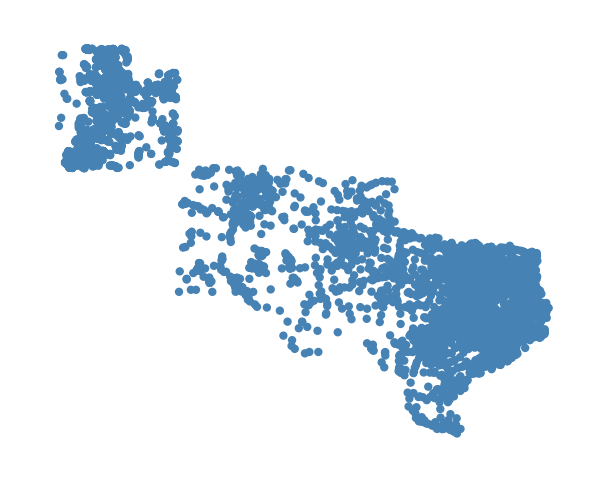

In [30]:
# map points
# convert dataframe to geodataframe
gdf_sites = gpd.GeoDataFrame(df_sites, geometry=gpd.points_from_xy(df_sites.Longitude.astype(float), df_sites.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdf_sites)

C:\Users\rjame\anaconda3\lib\site-packages\geoplot\geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

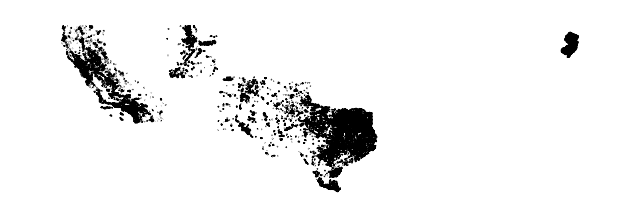

In [31]:
# map polygons
gplt.polyplot(gdf_poly)

AttributeError: 'LineString' object has no attribute 'exterior'

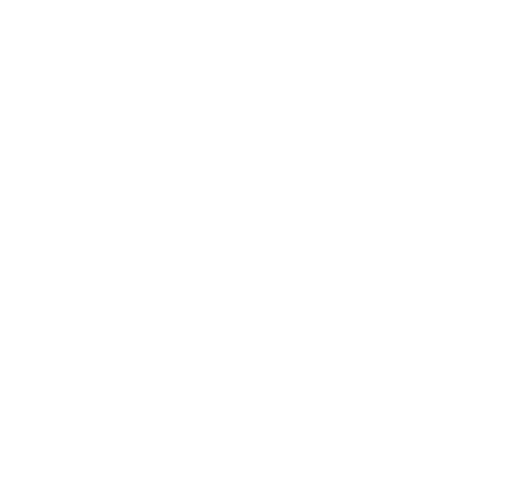

In [32]:
# map Lines
gplt.polyplot(gdf_lines)

In [ ]:
# # Issue of ESRI Shapefile does not support datetime fields

# dfs['minTimeFrameStart'] = pd.to_datetime(dfs['minTimeFrameStart'], errors = 'coerce')
# dfs['maxTimeFrameEnd'] = pd.to_datetime(dfs['maxTimeFrameEnd'], errors = 'coerce')
# print(dfs['minTimeFrameStart'].min())
# print(dfs['maxTimeFrameEnd'].max())

### Testing simplify geometry